# Laboratorium 11
### Generatory Liczb Losowych

Najpierw zaimportujmy potrzebne biblioteki i zainicjuję generator PCG.

In [1]:
from random import random as MTRand
from numpy.random import default_rng as PCG64Rand # PCG64 is the default
from scipy.stats import shapiro as ShWiTest
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scp
from scipy.stats import norm

In [2]:
PCGRand = PCG64Rand()

### 1. Testowanie generatorów liczb losowych

Dla obydwu generatorów liczb losowych (Mersenne Twister oraz PCG64) oraz dla n = 10, 1000, 5000 wylosuj n liczb losowych pochodzących z rozkładu jednostajnego i wykonaj następujące kroki.

In [3]:
N=[10, 1000, 5000]

In [4]:
def genNUni(gen, n):
    res = []
    for i in range(n):
        res += [gen()]
    return res

##### 1) Zwizualizuj na wykresie rozkład liczb w 10 równych przedziałach.

In [5]:
def visUni(gen, n, title, ix, normalise=True):
    los = genNUni(gen, n)
    plt.subplot(1,2,ix)
    plt.hist(los, 10, (0,1), density=normalise, edgecolor="black")
    plt.title(title)
#     plt.show()

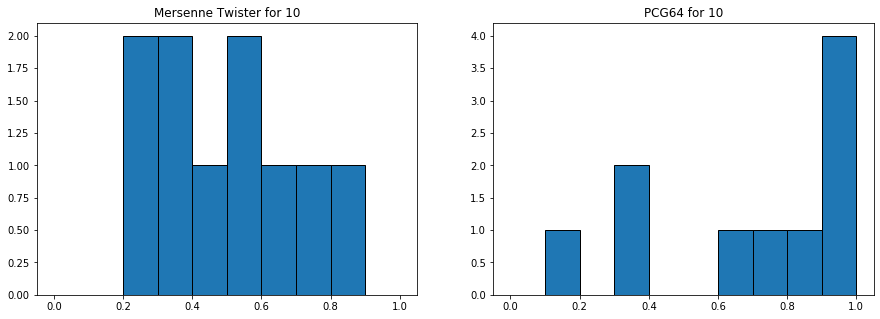

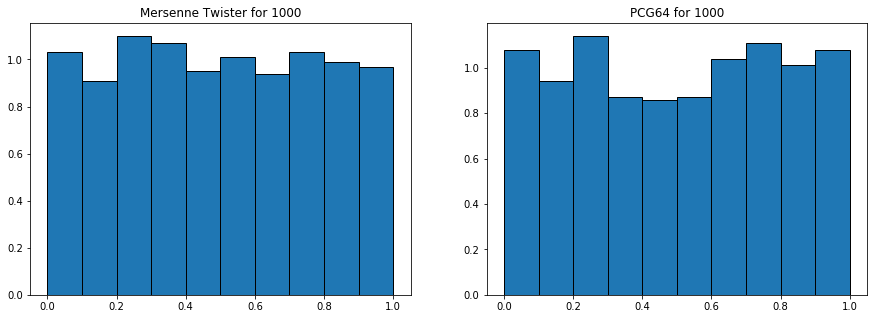

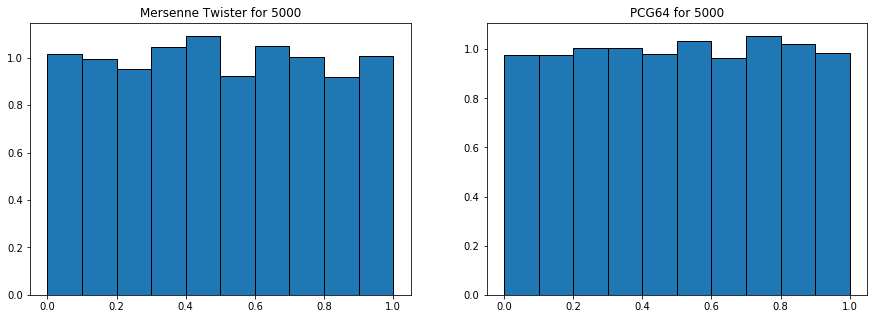

In [6]:
for i in N:
    plt.figure(figsize=(15,5))
    visUni(MTRand, i, "Mersenne Twister for "+str(i), 1, True)
    visUni(PCGRand.uniform, i, "PCG64 for "+str(i), 2, True)
    plt.show()

Jak widać na histogramach, oba generatory ładnie losują liczby jednostajnie na przedziale (0,1) - jakbyśmy chcieli inny przedział, można to bardzo łatwo osiągnąć, wykonując działania arytmetyczne mnożenia/dzielenia i dodawania/odejmowania.\
Próba 10 jest zbyt mała żeby wyciągać jakiekolwiek wnioski, dla coraz większych n można wyciągać mocniejsze wnioski. Jak u nas widać, już dla n=1000 histogram wygląda bardzo ładnie i reprezentuje losowanie z rozkładu jednostajnego, a dla n=5000 jest tylko jeszcze lepiej.\
Oczywiście wiadomo, że są drobne odstępstwa(w jakimś przedziale jest "znacznie"(bez przesady, ale jednak widocznie) mniej/więcej wartości), ale te odstępstwa się zmieniają i pamiętajmy, że jest to oczekiwana cecha generatora liczb losowych by losowane wartości nie były zawsze w 100% zgodne z oczekiwaniami.

##### 2) Sprawdź dla ilu liczb spełniona jest nierówność $x_i$ < $x_{i+1}$. Ile powinno ich być dla idealnego generatora?

In [7]:
def testineq(gen, n, title, ix, normalise=True):
    los = genNUni(gen, n)
    pas = [y for x, y in zip(los, los[1:]) if y > x]
#     print(los)
#     print(pas)
    plt.subplot(1,2,ix)
    plt.hist(los, 1, (0,1), edgecolor="black", facecolor="blue")
    plt.hist(pas, 1, (0,1), edgecolor="black", facecolor="red", alpha=0.5)
    plt.title(title+f" ratio = {(len(pas)/len(los))*100:.2f}%")
#     print(title+f" ratio = {len(pas)/len(los)*100:.2f}%")
    

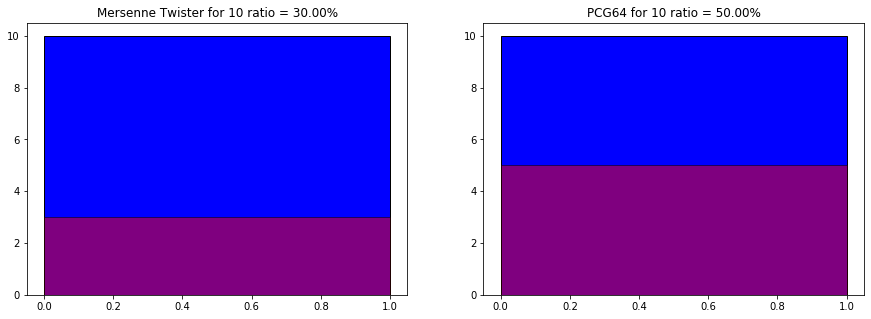

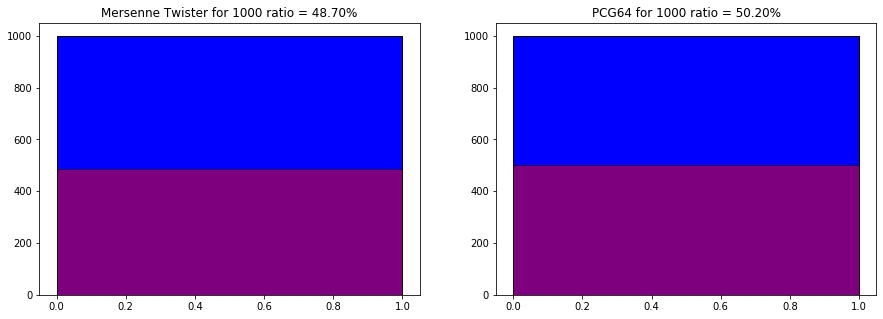

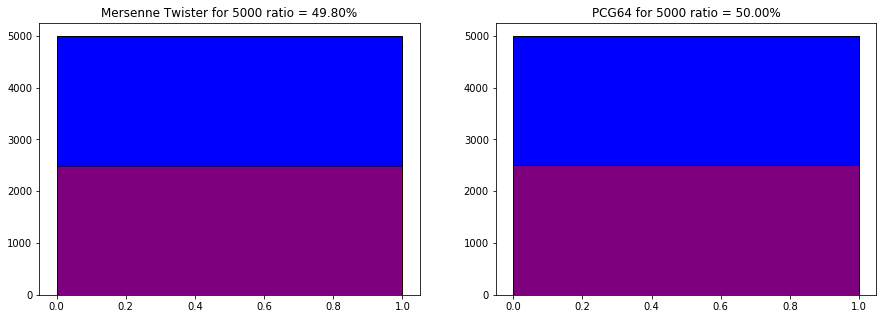

In [8]:
for i in N:
    plt.figure(figsize=(15,5))
    testineq(MTRand, i, "Mersenne Twister for "+str(i), 1, True)
    testineq(PCGRand.uniform, i, "PCG64 for "+str(i), 2, True)
plt.show()

Jak widać, dla każdego generatora, wychodzi ładnie mniej więcej 50% liczb spełaniających warunek $x_i<x_{i+1}$, czyli tak jak byśmy oczekwiali dla rozkłądu jednostajnego. Powinno być mniej więcej tyle samo sekwenecji dwuelementowych gdzie elementy są rosnące, co takich gdzie elementy są malejące. Oczywiście znowu nie bierzemy pod uwagę próby 10, która jest zbyt mała by można było na jej podstawie o czymś wnioskować.

##### 3) Zaimplementuj jeden z testów i wykorzystaj go do sprawdzenia wylosowanego ciągu liczb.
https://csrc.nist.gov/publications/detail/sp/800-22/rev-1a/final

Wybrałem test opisany w rozdziale 2.4 "Test for the Longest Run of Ones in a Block".\
Będziemy sprawdzać najdłuższe ciągi jedynek w blokach długości M(sami sobie na te bloki podzielimy).\
Przyrównamy wyniki do oczekiwanych w losowych sekwencjach.\
Dla sekwencji długości n<128 - nie ma co testować, n<6272 - M=8, n<750000 - M=128, n>=750000 - M=10000.\
Dla konkretnych M, są inne oczekiwania. Przedstawmy w tabelce oczekiwania ile powinno być takich ciągów, odpowiedniej długości (długości i w $v_i$).\


| $v_i$ | M=8 | M=128 | M=$10^4$ |
| ----- | ---- | ---- | ------- | 
| $v_0$ | $\leq 1$  | $\leq 4$  | $\leq 10$  |
| $v_1$ | 2 | 5 | 11 |
| $v_2$ | 3 | 6 | 12 |
| $v_3$ | $\geq 4$ | 7 | 13 |
| $v_4$ |  | 8 | 14 |
| $v_5$ |  | $\geq 9$ | 15 |
| $v_6$ |  |  | $\geq 16$ |


Wyliczymy $\chi^2(obs)=\sum\limits_{i=0}^{K}\frac{(v_i-N\pi_i)^2}{N\pi_i}$ i możemy wyznaczyć $P-value=igamc(K/2, \frac{\chi^2(obs)}{2})$, dla $\pi_i$ jest dane w tabelce(której raczej nie ma sensu tu przytaczać, ale jest podana w artykule).\
Na tej podstawie będziemy sprawdzać czy p-value zadanej statystyki będzie mniejsze niż 0.01, wtedy będziemy mieli podstawy aby odrzucić hipotezę, że generujemy liczby losowe, w innym przypadku nie będziemy mieć takiej podstawy by odrzucić twierdzenie że generator jest generatorem liczb losowych.

In [9]:
def testLongest(arr, bi="", rou=False, ints=-1):
    if bi=="":
        if ints!=-1:
            for i in arr:
                bi+=('{:0'+str(ints)+'b}').format(int(i*(2**ints)))
        elif rou==False:
            for i in arr:
                bi+='{:032b}'.format(np.float32(i).view(np.int32))
        else:
            for i in arr:
                bi+=str(int(round(i)))
            
    if len(bi)<128:
        print('We need more data!')
        return -1.
    if len(bi)<6272:
        k,m=3,8
        vs=[1,2,3,4]
        piks = [0.21484375, 0.3671875, 0.23046875, 0.1875]
    elif len(bi)<750000:
        k,m=5,128
        vs=[4,5,6,7,8,9]
        piks = [0.1174035788, 0.242955959, 0.249363483, 0.17517706, 0.102701071, 0.112398847]
    else:
        k,m=6,10000
        vs=[10,11,12,13,14,15,16]
        piks = [0.0882, 0.2092, 0.2483, 0.1933, 0.1208, 0.0675, 0.0727]
    
    blocks = len(bi)//m
    frq = np.zeros(k+1)
    for i in range(blocks):
        block = bi[i*m:(i+1)*m]
        mrun,run = 0,0
        for j in block:
            if j=='1':
                run += 1
                mrun = max(mrun, run)
            else:
                run=0
        mrun = max(mrun, run)
        if mrun < vs[0]:
            frq[0] += 1
        elif mrun > vs[-1]:
            frq[-1] += 1
        else:
            for j in range(len(frq)):
                if mrun == vs[j]:
                    frq[j] += 1
    chisq = 0
    frq = np.array(frq)
    piks = np.array(piks)
    chisq = np.sum((frq-blocks*piks)**2/(blocks*piks))
    pv = scp.gammaincc(float(k/2), float(chisq/2))
    return pv

Funkcja testLongest - funkcja przyjmuje tablice floatów wylosowanych przez generator, zamienia ją na długi ciąg bitów, na którym wykonuje test i zwraca wynik. Korzysta z scipy.special.gammaincc do wyznaczenia szukanego p-value. Poniżej przedstawiono wyniki dla przykładu z artykułu, które są zgodne z oczekiwanymi.

In [10]:
testLongest(0,"11001100000101010110110001001100111000000000001001001101010100010001001111010110100000001101011111001100111001101101100010110010")

0.1806093182397121

In [11]:
for i in N:
    pv=testLongest(genNUni(MTRand, i))
    print(f"For Mersenne Twister and {i} numbers, P-value={pv} Is generator random? {pv>0.01}")
    testLongest(genNUni(PCGRand.uniform, i))
    print(f"For PCG64 and {i} numbers, P-value={pv} Is Generator random? {pv>0.01}")

For Mersenne Twister and 10 numbers, P-value=0.021731190798349558 Is generator random? True
For PCG64 and 10 numbers, P-value=0.021731190798349558 Is Generator random? True
For Mersenne Twister and 1000 numbers, P-value=6.694661939302592e-51 Is generator random? False
For PCG64 and 1000 numbers, P-value=6.694661939302592e-51 Is Generator random? False
For Mersenne Twister and 5000 numbers, P-value=0.0 Is generator random? False
For PCG64 and 5000 numbers, P-value=0.0 Is Generator random? False


In [12]:
cs = "Can't say"
for i in N+[1000000]:
    pv=testLongest(genNUni(MTRand, i), rou=True)
    print(f"For Mersenne Twister and {i} numbers, P-value={pv} Is generator random? {pv>0.01 if pv!=-1.0 else cs}")
    testLongest(genNUni(PCGRand.uniform, i), rou=True)
    print(f"For PCG64 and {i} numbers, P-value={pv} Is Generator random? {pv>0.01 if pv!=-1.0 else cs}")

We need more data!
For Mersenne Twister and 10 numbers, P-value=-1.0 Is generator random? Can't say
We need more data!
For PCG64 and 10 numbers, P-value=-1.0 Is Generator random? Can't say
For Mersenne Twister and 1000 numbers, P-value=0.8618583596511272 Is generator random? True
For PCG64 and 1000 numbers, P-value=0.8618583596511272 Is Generator random? True
For Mersenne Twister and 5000 numbers, P-value=0.7654195422800657 Is generator random? True
For PCG64 and 5000 numbers, P-value=0.7654195422800657 Is Generator random? True
For Mersenne Twister and 1000000 numbers, P-value=0.5479029310208989 Is generator random? True
For PCG64 and 1000000 numbers, P-value=0.5479029310208989 Is Generator random? True


Wadą testu najdłuższego ciągu jedynek w bloku jest to, że wymaga podania ciągu bitów. Zastosowaliśmy dwa podejścia.\
Najpierw przetestowaliśmy czy konkatenacja binarnych zapisów float32 liczb wylosowanych przez generatory przechodzi ten test, później sprawdziliśmy czy ten sam test przejdą bity utworzone zaokrąglając float32 do pełnych intów (0 albo 1). Pamiętajmy, że w pierwszym przypadku dostajemy dużo więcej bitów (z każdej liczby 32, w porównaniu do 1 przy zaokrąglaniu), dlatego do zaokrąglania dodałem test dla n=1000000.\
Jak się okazuje żaden z generatorów nie jest "świetny" i często się zdarza, że nie przechodzą testów, szczególnie w pierwszym podejściu.\
Zwrócmy uwagę na znaczenie:
- Generujemy liczby dziesiętne jednostajnie w przedziale [0,1) (a przynajmniej chcielibyśmy), jednak musimy pamiętać o wadzie reprezentacji binarnej, która zdecydowanie nie jest jednostajna(jeśli chodzi o odlegości między kolejnymi zdyskretyzowanymi wartościami), a później testujemy czy zapis binarny tych liczb jest generowany losowo(w pierwszym przypadku) oraz czy losowo występuja liczby większe i mniejsze od 0.5(w drugim przypadku).

Nie ma więc co się dziwić, że w pierwszym przypadku często wychodzi, że generator nie przechodzi testu. W drugim przypadku bardzo rzadko wylosowane liczby są odrzucane jako nie losowe, co ma więcej sensu, bo dużo łatwiej zagwarantować 50% na liczby większe/mniejsze od 0.5.

Jako 3 wersję spróbujemy pomnożyć wszystkie liczby wygenerowane razy 1024, i będziemy konkatenować reprezentację binarną (dla liczb 10 bitowych).\
Zasadniczo powtórzym pierwsze rozumowanie, jedynie dla liczb całkowitych, dla którch już możemy oczekiwać jednostajnego rozkładu i losowo rozłożonych bitów.

In [13]:
cs = "Can't say"
for i in N+[100000]:
    pv=testLongest(genNUni(MTRand, i), ints=10)
    print(f"For Mersenne Twister and {i} numbers, P-value={pv} Is generator random? {pv>0.01 if pv!=-1.0 else cs}")
    testLongest(genNUni(PCGRand.uniform, i), ints=10)
    print(f"For PCG64 and {i} numbers, P-value={pv} Is Generator random? {pv>0.01 if pv!=-1.0 else cs}")

We need more data!
For Mersenne Twister and 10 numbers, P-value=-1.0 Is generator random? Can't say
We need more data!
For PCG64 and 10 numbers, P-value=-1.0 Is Generator random? Can't say
For Mersenne Twister and 1000 numbers, P-value=0.574354185173232 Is generator random? True
For PCG64 and 1000 numbers, P-value=0.574354185173232 Is Generator random? True
For Mersenne Twister and 5000 numbers, P-value=0.6428631587358103 Is generator random? True
For PCG64 and 5000 numbers, P-value=0.6428631587358103 Is Generator random? True
For Mersenne Twister and 100000 numbers, P-value=0.9423310955073854 Is generator random? True
For PCG64 and 100000 numbers, P-value=0.9423310955073854 Is Generator random? True


Jak widać tym razem oba generatory, zgodnie z naszymi oczekiwaniami, zdają testy ta losowość ciągów bitów.

Oba generatory są pseudolosowe, więc mają swoje wady, jednak jeśli umie się z nich dobrze korzystać to może wiele błędów zniwelować i otrzymać bardzo dobre i statystycznie poprwane generatory liczb losowych. Żaden z tych generatorów się nie wyróżnił pod żadnym względem przy powyższych testach.\
Można zauważyć zależność, że im większe n tym bardziej przewidywalne stają się wyniki(jeśli chodzi o całość rezultatów, a nie pojedyncze losowania).

### 2. Generowanie liczb z rozkładu normalnego

Zaimplementuj generator liczb losowych pochodzących z rozkładu normalnego za pomocą metody Boksa-Mullera i zaprezentuj wyniki dla n = 10, 100, 5000 wygenerowanych liczb. Funkcja powinna dodatkowo przyjmować wartość oczekiwaną oraz odchylenie standardowe jako parametry.

Na podstawie dwóch liczb z rozkładu jednostajnego [0,1), będziemy generować 2 liczby z rozkładu normalnego.\
Traktujemy dane liczby jako współrzędne kartezjańskie i zmieniamy je na polarne, po czym sprawdzamy czy $R^2=-2ln(U_1)$ i $\Theta=2\pi U_2$, wówczas R i $\Theta$ są niezależne.

W ten sposób otrzymujemy zmienne z rozkładu normalnego ustandaryzowanego. Chcemy przyjąć jako argumenty wartość oczekiwaną i odchylenie standardowe, a następnie na ich podstawie zmodyfikować wyliczenia zmiennych tak aby one spełniały założenia.\
Wartość oczekiwaną bardzo łatwo zmienić, dodając ją po prostu do zmiennych na sam koniec.\
Aby zmienić odchylenie standardowe, musimy przed dodaniem wartości oczekiwanej, pomnożyć nasze wyliczone wartości razy odchylenie standardowe.

In [14]:
def gen2NNorm(n, mu, sig):
    res = []
    MT = genNUni(MTRand, n)
    PCG = genNUni(PCGRand.uniform, n)
    ran = MT+PCG
    np.random.shuffle(ran)
    for U1, U2 in zip(ran[0::2], ran[1::2]):
        Z1 = np.sqrt(-2*np.log(U1))*np.cos(2*np.pi*U2)
        Z2 = np.sqrt(-2*np.log(U1))*np.sin(2*np.pi*U2)
        res += [Z1*sig+mu, Z2*sig+mu]
    return res

Funkcja gen2NNorm generuje 2n liczb losowo wygenerowanych z rozkładu normalnego o danym odchyleniu standardowym i wartości oczekiwanej.

##### 1) Zwizualizuj na wykresie rozkład liczb w 10 równych przedziałach. Na tym samym wykresie umieść funkcję gęstości prawdopodobieństwa rozkładu normalnego o takich samych parametrach.

In [15]:
def vis(n, mu, sig, title):
    los = gen2NNorm(n//2, mu, sig)
    ran = (mu-2*sig, mu+2*sig) if sig>0 else (mu+2*sig, mu-2*sig)
    plt.hist(los, 10, ran, density=True, edgecolor="black")
    xs = np.linspace(*ran, 10*4)
    plt.plot(xs, norm.pdf(xs, mu, sig))
    plt.title(title)
    plt.show()

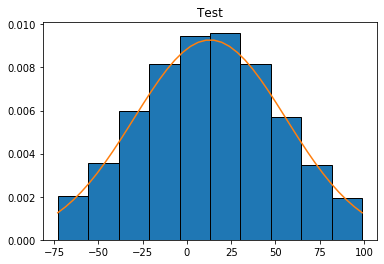

In [16]:
vis(10000, 13, 43, 'Test')

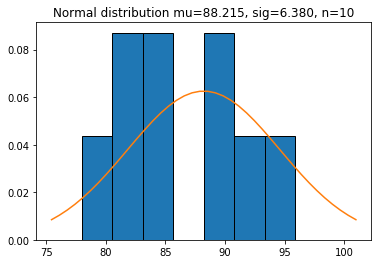

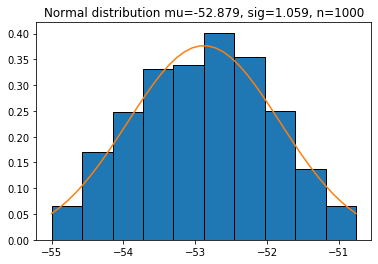

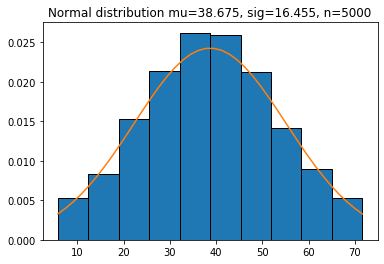

In [17]:
for i in N:
    mu,sig = (PCGRand.uniform()-0.5)*200, MTRand()*37
    vis(i, mu, sig, f'Normal distribution mu={mu:.3f}, sig={sig:.3f}, n={i}')

Jak widać na wykresach, dla większych n(10 to za mała próba) histogram ładnie wpisuje się w wykres gęstości rozkładu normalnego o zadanych parametrach, co sugeruje, że implementacja jest poprawna.

##### 2) Wykonaj test statystyczny Shapiro-Wilka, przedstaw uzyskaną p-wartość, informację czy hipoteza zerowa została przyjęta/odrzucona dla α = 0,05 i czy w związku z tym są podstawy do stwierdzenia że liczby pochodzą z rozkładu normalnego.

In [18]:
for i in N:
    mu,sig = (PCGRand.uniform()-0.5)*31, MTRand()*29
    pv=ShWiTest(gen2NNorm(i//2, mu, sig))
    print(f"For {i} numbers, P-value={pv[1]} Normal distribution of random numbers? {pv[1]>0.05}")

For 10 numbers, P-value=0.6859802603721619 Normal distribution of random numbers? True
For 1000 numbers, P-value=0.44218719005584717 Normal distribution of random numbers? True
For 5000 numbers, P-value=0.833343505859375 Normal distribution of random numbers? True


Jak widać, generator przechodzi testy Shapiro-Wilka, dzięki czemu nie mamy podstaw do odrzecenia hipotezy, że liczby generowane są zgodnie z rozkładem normalnym.

### 3. Metoda Monte Carlo

Napisz funkcję która zwróci przybliżoną wartość liczby pi wykorzystującą metodę Monte Carlo do obliczenia pola powierzchni koła jednostkowego. Funkcja powinna przyjmować liczbę wylosowanych punktów jako parametr. Zwizualizuj koło, zaznaczając na jednym kolorem punkty które trafiły do jego wnętrza, a drugim te które trafiły na zewnątrz. Na wykresie zwizualizuj błąd bezwzględny wraz z rosnącą liczbą punktów

Losoujemy n punktów z rozkładem jednostajnym, z wnętrza kostki [-1, 1]^2 i sprawdzamy ile punktów jest w odległości mniejszej niż 1 od środka. Stosunek punktów wewnątrz koła, do wszystkich punktów przybliża stosunek pól koła o promieniu 1 do kwadratu 2x2.\
PI = 4*(liczba punktów wewnątrz koła)/(liczba wszystkich punktów)

In [19]:
def MCPI(n, draw=True):
    pts = np.array(genNUni(PCGRand.uniform, 2*n))*2-1
    pts = np.array(list(zip(pts[0::2], pts[1::2])))
    
    radii = []
    for i in range(n):
        radii.append(pts[i][0]**2+pts[i][1]**2)
    
    radii = np.array(radii)
    inner = pts[radii<=1]
    outer = pts[radii>1]
    
    if draw:
        plt.scatter(*inner.T, color='green')
        plt.scatter(*outer.T, color='red')
        plt.ylim(-1,1)
        plt.xlim(-1,1)
        plt.show()
    
    pi = 4.0*len(inner)/n
    return pi

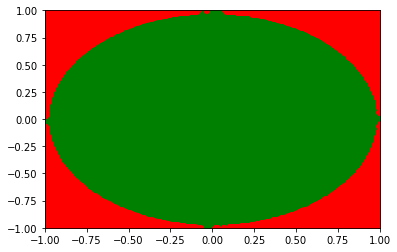

3.13896

In [20]:
MCPI(100000)

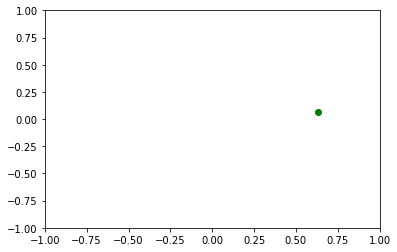

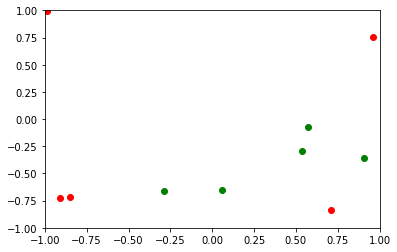

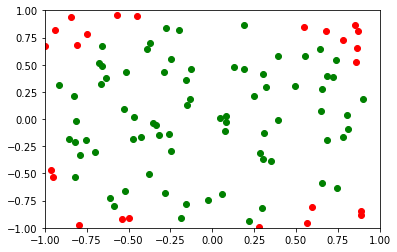

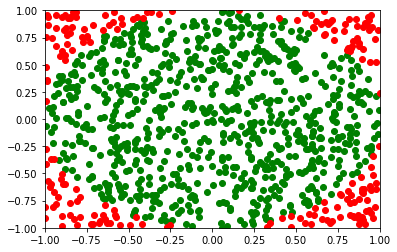

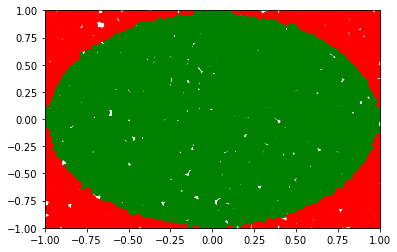

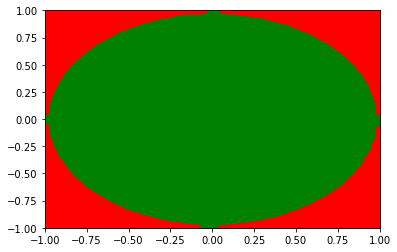

In [21]:
pis=[]
for i in range(6):
    pis.append(MCPI(10**i))

[-0.00460787 -0.02061694 -0.00584654  0.04602158  0.00317918  0.00081341
  0.00932913  0.00818572 -0.005178    0.0075842 ]


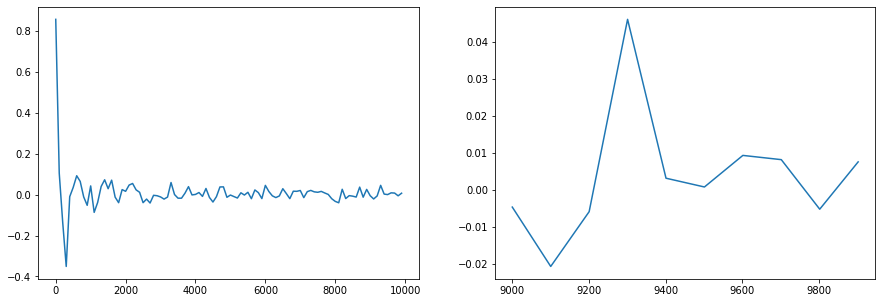

In [22]:
xs = np.empty(100)
ys = np.empty(100)
for i in range(1, 10001, 100):
    xs[i//100]=i
    ys[i//100]=MCPI(i,False)-np.pi
    print(i, end='\r')

print(ys[-10:])
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(xs, ys)
plt.subplot(1,2,2)
plt.plot(xs[-10:], ys[-10:])
plt.show()

Jak widać dla dużych n, metoda Monte Carlo bardzo dobrze przybliża pi.